In [1]:
import gammapy
import numpy as np
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.io import fits
from gammapy.data import DataStore
from gammapy.datasets import Datasets, FluxPointsDataset, SpectrumDataset
from gammapy.estimators import FluxPointsEstimator
from gammapy.makers import (
    ReflectedRegionsBackgroundMaker,
    SafeMaskMaker,
    SpectrumDatasetMaker,
)
from gammapy.maps import Map, MapAxis, RegionGeom
from gammapy.modeling import Fit
from gammapy.modeling.models import (
    LogParabolaSpectralModel,
    SkyModel,
    create_crab_spectral_model,
)
from gammapy.visualization import plot_spectrum_datasets_off_regions
from matplotlib import pyplot as plt
from regions import CircleSkyRegion

In [2]:
# Gammapy version 0.19, which is installed in the default magic-cta-pipe
# environment, cannot use dynamic (energy-dependent) theta cuts for the
# point-like 1D spectral analysis. If you want to use them, please run
# this notebook with different environment where the newer version of
# gammapy is installed.

gammapy_ver = gammapy.__version__
print(f"gammapy: v{gammapy_ver}")

is_new_ver = gammapy_ver.startswith("0.20")

if is_new_ver:
    from gammapy.makers import WobbleRegionsFinder
    from regions import PointSkyRegion

else:
    print("\nWARNING: The dynamic theta cuts cannot be used with this version.")

gammapy: v0.20.1


In [3]:
# Customize the pyplot figure:
plt.rcParams.update(
    {"figure.figsize": (12, 9), "font.size": 15, "grid.linestyle": "--"}
)

# Load DL3 data

In [4]:
# ================
# === Settings ===
# ================

input_dir = (
    "/home/yoshiki.ohtani/lstmagic/real/CrabNebula/2020_12_15/"
    "5.dl2_to_dl3/data/dl3/software_only_3tel_gh_dyn0.9_theta_glob0.2deg/"
)

obs_ids = [3267, 3268]

# input_dir = (
#     "/home/yoshiki.ohtani/lstmagic/real/CrabNebula/2020_12_15/"
#     "magic_only_analysis/5.dl2_to_dl3/data/dl3/"
# )

# obs_ids = [5093713, 5093714]

# ============
# === Main ===
# ============

data_store = DataStore.from_dir(input_dir)

if obs_ids == "all":
    # Load all the data in the input directory
    obs_ids = data_store.obs_table["OBS_ID"].value

observations = data_store.get_observations(obs_ids, required_irf=["aeff", "edisp"])

print(observations)

Observations
Number of observations: 2
Observation

	obs id            : 3267 
 	tstart            : 59198.92
	tstop             : 59198.93
	duration          : 815.54 s
	pointing (icrs)   : 84.0 deg, 22.2 deg

	deadtime fraction : 4.7%
Observation

	obs id            : 3268 
 	tstart            : 59198.93
	tstop             : 59198.94
	duration          : 775.56 s
	pointing (icrs)   : 83.3 deg, 21.8 deg

	deadtime fraction : 4.6%



# Define a target region

In [5]:
# Read one of the input files to get the metadata
file_name = data_store.hdu_table["FILE_NAME"][0]
input_file = f"{input_dir}/{file_name}"

hdus = fits.open(input_file)
event_header = hdus["EVENTS"].header

# Define the target position
target_position = SkyCoord(
    u.Quantity(event_header["RA_OBJ"], u.deg),
    u.Quantity(event_header["DEC_OBJ"], u.deg),
    frame="icrs",
)

if "RAD_MAX" in hdus:
    on_region = PointSkyRegion(target_position)

else:
    # Get the global theta cut used for creating the IRFs
    aeff_header = hdus["EFFECTIVE AREA"].header
    on_region_radius = u.Quantity(aeff_header["RAD_MAX"], u.deg)

    on_region = CircleSkyRegion(center=target_position, radius=on_region_radius)

print(on_region)

Region: CircleSkyRegion
center: <SkyCoord (ICRS): (ra, dec) in deg
    (83.63308333, 22.0145)>
radius: 0.2 deg


# Run the data reduction chain

In [6]:
# ================
# === Settings ===
# ================

energy_reco_min = 0.1  # unit: [TeV]
energy_reco_max = 3.95  # unit: [TeV]
n_reco_bins_pdec = 5

energy_true_min = 0.01  # unit: [TeV]
energy_true_max = 100  # unit: [TeV]
n_true_bins_pdec = 10

n_off_regions = 3

# ============
# === Main ===
# ============

energy_axis = MapAxis.from_energy_bounds(
    energy_reco_min,
    energy_reco_max,
    nbin=n_reco_bins_pdec,
    per_decade=True,
    unit="TeV",
    name="energy",
)

print(f"Reconstructed energy axis:\n{energy_axis.edges}")

energy_axis_true = MapAxis.from_energy_bounds(
    energy_true_min,
    energy_true_max,
    nbin=n_true_bins_pdec,
    per_decade=True,
    unit="TeV",
    name="energy_true",
)

on_geom = RegionGeom.create(region=on_region, axes=[energy_axis])
dataset_empty = SpectrumDataset.create(geom=on_geom, energy_axis_true=energy_axis_true)

dataset_maker = SpectrumDatasetMaker(
    containment_correction=False,
    selection=["counts", "exposure", "edisp"],
    use_region_center=True,
)

if is_new_ver:
    print(f"\nNumber of OFF regions: {n_off_regions}")

    region_finder = WobbleRegionsFinder(n_off_regions=n_off_regions)
    bkg_maker = ReflectedRegionsBackgroundMaker(region_finder=region_finder)

else:
    bkg_maker = ReflectedRegionsBackgroundMaker(
        min_distance=u.Quantity(100, u.deg), max_region_number=1
    )

safe_mask_maker = SafeMaskMaker(methods=["aeff-max"], aeff_percent=10)

Reconstructed energy axis:
[0.1        0.15833417 0.25069708 0.39693913 0.62849025 0.9951148
 1.57560671 2.49472373 3.95      ] TeV

Number of OFF regions: 3


In [7]:
datasets = Datasets()

counts = Map.create(skydir=target_position, width=3)

for obs_id, observation in zip(obs_ids, observations):

    counts.fill_events(observation.events)

    dataset = dataset_maker.run(dataset_empty.copy(name=str(obs_id)), observation)
    dataset_on_off = bkg_maker.run(dataset, observation)
    dataset_on_off = safe_mask_maker.run(dataset_on_off, observation)

    datasets.append(dataset_on_off)

print(datasets)

Datasets
--------

Dataset 0: 

  Type       : SpectrumDatasetOnOff
  Name       : 3267
  Instrument : CTA-N
  Models     : 

Dataset 1: 

  Type       : SpectrumDatasetOnOff
  Name       : 3268
  Instrument : CTA-N
  Models     : 




<WCSAxesSubplot: >

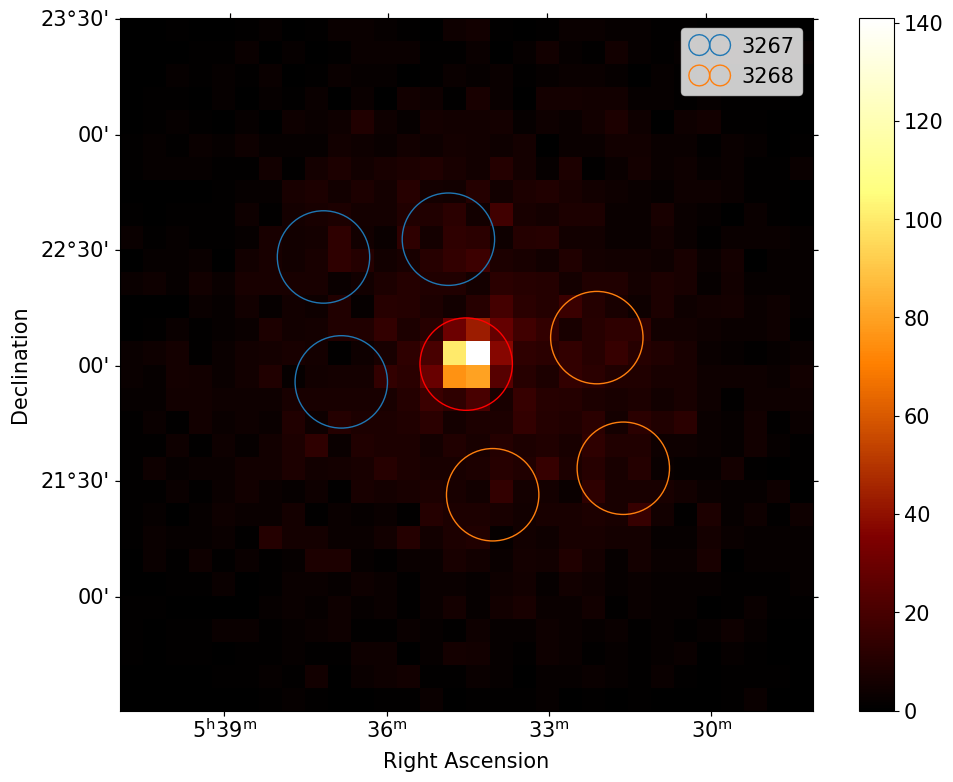

In [8]:
plt.figure()

# Plot the count map
ax = counts.plot(add_cbar=True)

# Plot the ON and OFF positions
on_geom.plot_region(ax=ax, edgecolor="red")
plot_spectrum_datasets_off_regions(datasets, ax)

# Check source statistics

In [9]:
info_table = datasets.info_table(cumulative=True)

In [10]:
info_table

name,counts,excess,sqrt_ts,background,npred,npred_background,npred_signal,exposure_min,exposure_max,livetime,ontime,counts_rate,background_rate,excess_rate,n_bins,n_fit_bins,stat_type,stat_sum,counts_off,acceptance,acceptance_off,alpha
,,,,,,,,m2 s,m2 s,s,s,1 / s,1 / s,1 / s,,,,,,,,
str7,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,str5,float64,int64,float64,float64,float64
stacked,269,226.0,17.84989796096219,43.0,99.50000217370687,99.50000217370687,nan,374.0802307128906,226194560.0,777.5930027542769,815.5370678901672,0.3459393269321963,0.05529885151704253,0.29064047541515375,8,7,wstat,333.07773897413307,129,7.0,21.0,0.3333333432674408
stacked,485,395.3333435058594,22.73688580457002,89.66666412353516,188.50000473298127,188.50000473298127,nan,729.9772338867188,441394304.0,1517.388917575117,1591.093656539917,0.31962800992052887,0.05909273692787221,0.2605352780206323,8,7,wstat,563.0181119422224,269,7.0,21.000001907348633,0.3333333134651184


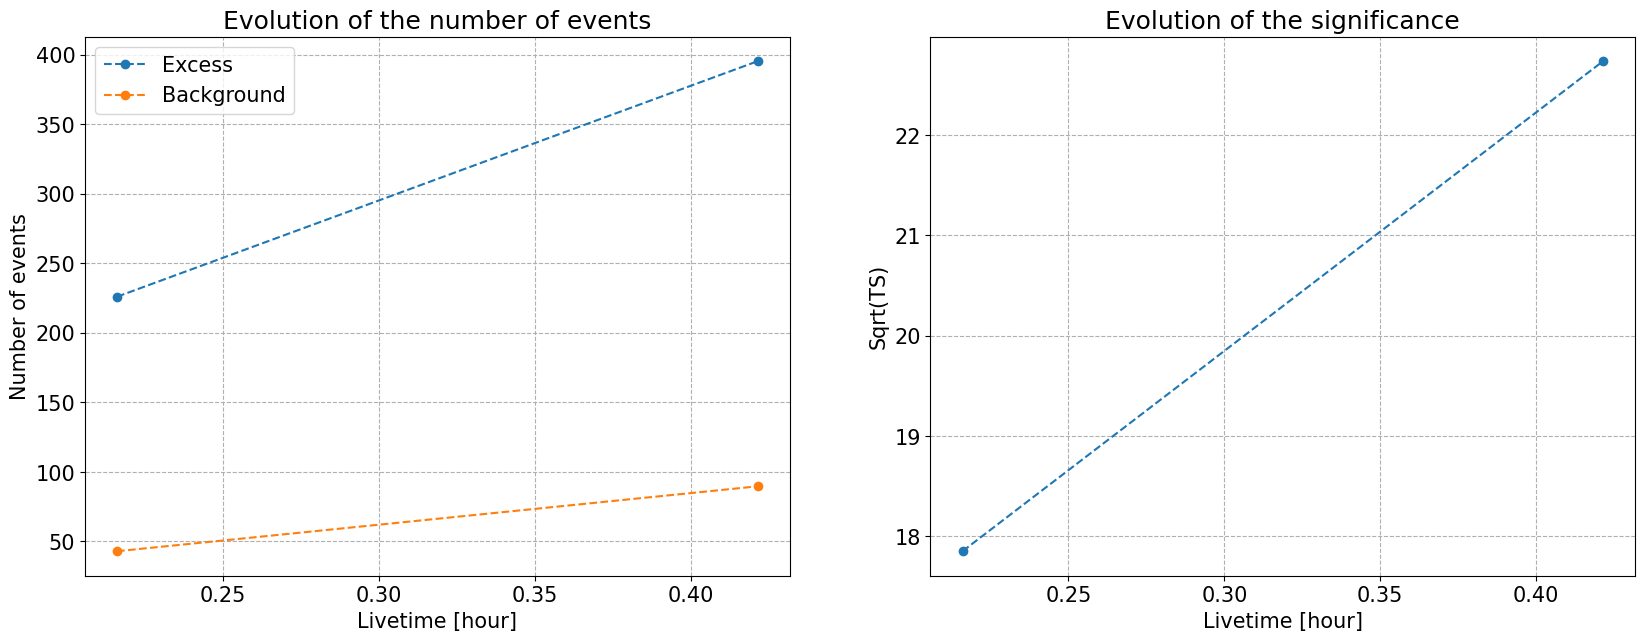

In [11]:
plt.figure(figsize=(20, 7))
grid = (1, 2)

# Plot the number of events along the livetime
plt.subplot2grid(grid, (0, 0))
plt.title("Evolution of the number of events")
plt.xlabel("Livetime [hour]")
plt.ylabel("Number of events")

plt.plot(
    info_table["livetime"].to("h"),
    info_table["excess"],
    marker="o",
    linestyle="--",
    label="Excess",
)

plt.plot(
    info_table["livetime"].to("h"),
    info_table["background"],
    marker="o",
    linestyle="--",
    label="Background",
)

plt.grid()
plt.legend()

# Plot the significance along the livetime
plt.subplot2grid(grid, (0, 1))
plt.title("Evolution of the significance")
plt.xlabel("Livetime [hour]")
plt.ylabel("Sqrt(TS)")

plt.plot(
    info_table["livetime"].to("h"), info_table["sqrt_ts"], marker="o", linestyle="--"
)

plt.grid()

# Fit the spectrum

In [12]:
# ================
# === Settings ===
# ================

model_function = LogParabolaSpectralModel

parameters = {
    "amplitude": u.Quantity(5e-12, u.Unit("cm-2 s-1 TeV-1")),
    "alpha": u.Quantity(2),
    "beta": u.Quantity(0.1),
    "reference": u.Quantity(1, u.TeV),
}

# ============
# === Main ===
# ============

spectral_model = model_function(**parameters)
model = SkyModel(spectral_model=spectral_model, name="target_source")

stacked_dataset = datasets.stack_reduce()
stacked_dataset.models = model

fit = Fit()
results = fit.run(datasets=stacked_dataset)

print(results)

OptimizeResult

	backend    : minuit
	method     : migrad
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 130
	total stat : 0.84

CovarianceResult

	backend    : minuit
	method     : hesse
	success    : True
	message    : Hesse terminated successfully.



In [13]:
stacked_dataset.models.to_parameters_table()

model,type,name,value,unit,error,min,max,frozen,is_norm,link
str13,str8,str9,float64,str14,float64,float64,float64,bool,bool,str1
target_source,spectral,amplitude,2.8196e-11,cm-2 s-1 TeV-1,2.672e-12,nan,nan,False,True,
target_source,spectral,reference,1.0000e+00,TeV,0.000e+00,nan,nan,True,False,
target_source,spectral,alpha,2.7806e+00,,1.569e-01,nan,nan,False,False,
target_source,spectral,beta,2.3672e-01,,9.974e-02,nan,nan,False,False,


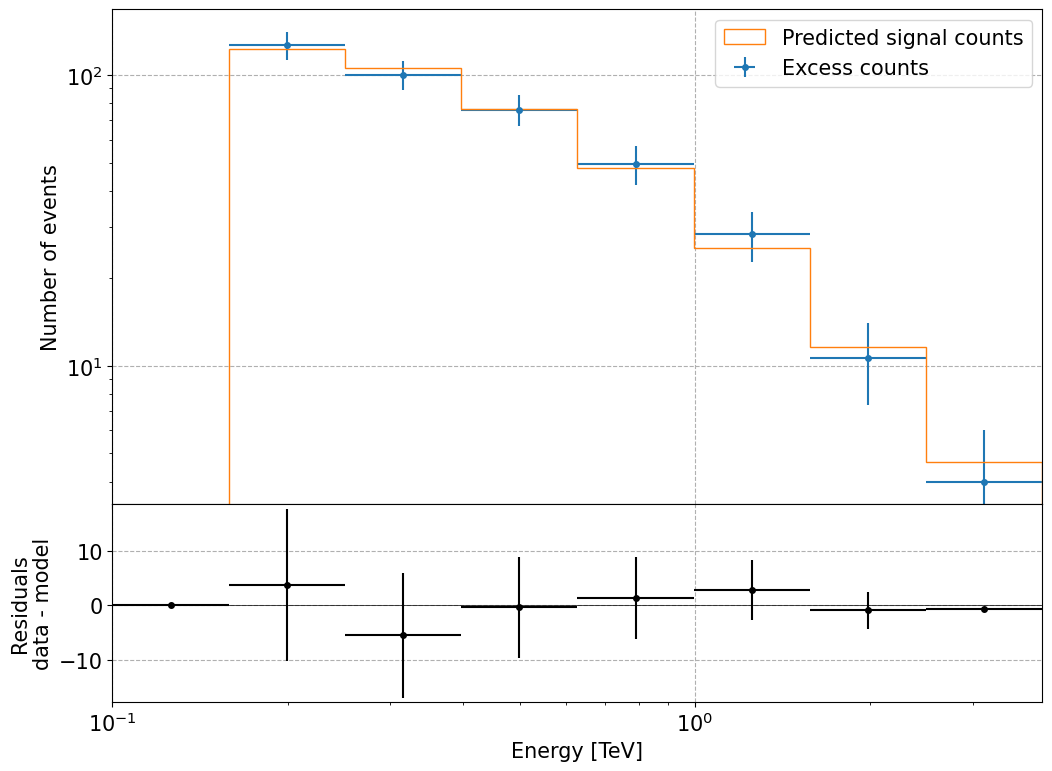

In [14]:
plt.figure()

ax_spectrum, ax_residuals = stacked_dataset.plot_fit()

ax_spectrum.set_ylabel("Number of events")
ax_spectrum.grid()

plt.setp(ax_spectrum.get_xticklabels(), visible=False)
plt.subplots_adjust(hspace=0)

ax_residuals.grid()

# Calculate the flux points

In [15]:
fpe = FluxPointsEstimator(
    energy_edges=energy_axis.edges, source="target_source", selection_optional="all"
)

flux_points = fpe.run(datasets=stacked_dataset)
flux_points_dataset = FluxPointsDataset(data=flux_points, models=stacked_dataset.models)

In [16]:
flux_points.to_table(sed_type="e2dnde", formatted=True)

e_ref,e_min,e_max,e2dnde,e2dnde_err,e2dnde_errp,e2dnde_errn,e2dnde_ul,ts,sqrt_ts,npred,npred_excess,stat,is_ul,counts,success,norm_scan,stat_scan
TeV,TeV,TeV,TeV / (cm2 s),TeV / (cm2 s),TeV / (cm2 s),TeV / (cm2 s),TeV / (cm2 s),,,,,,,,,,
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64[1],float32[1],float64,bool,float64[1],bool,float64[11],float64[11]
0.126,0.100,0.158,nan,nan,nan,nan,nan,nan,nan,nan,0.0,0.000,False,0.0,False,0.200 .. 5.000,nan .. nan
0.199,0.158,0.251,5.541e-11,6.094e-12,6.227e-12,5.970e-12,6.817e-11,124.578,11.161,177.93046168136317,126.92381,0.000,False,178.0,True,0.200 .. 5.000,75.286 .. 497.590
0.315,0.251,0.397,4.785e-11,5.470e-12,5.618e-12,5.324e-12,5.939e-11,129.954,11.400,123.00945396759268,100.01004,0.000,False,123.0,True,0.200 .. 5.000,72.940 .. 485.022
0.499,0.397,0.628,4.305e-11,5.273e-12,5.456e-12,5.094e-12,5.433e-11,132.290,11.502,83.99861876202769,75.99857,0.000,False,84.0,True,0.200 .. 5.000,75.072 .. 352.362
0.791,0.628,0.995,3.437e-11,5.256e-12,5.485e-12,5.041e-12,4.583e-11,83.570,9.142,54.96865300477847,49.300907,0.000,False,55.0,True,0.200 .. 5.000,48.531 .. 215.279
1.252,0.995,1.576,2.599e-11,5.071e-12,5.375e-12,4.779e-12,3.737e-11,57.346,7.573,29.99986923185184,28.3332,0.000,False,30.0,True,0.200 .. 5.000,34.547 .. 110.314
1.983,1.576,2.495,1.355e-11,4.233e-12,4.672e-12,3.836e-12,2.382e-11,24.190,4.918,10.978114761705736,10.64456,0.000,False,11.0,True,0.200 .. 5.000,12.724 .. 58.096
3.139,2.495,3.950,7.249e-12,3.624e-12,4.252e-12,3.047e-12,1.709e-11,11.090,3.330,3.9999687837605467,3.9999688,0.000,False,4.0,True,0.200 .. 5.000,5.482 .. 24.615


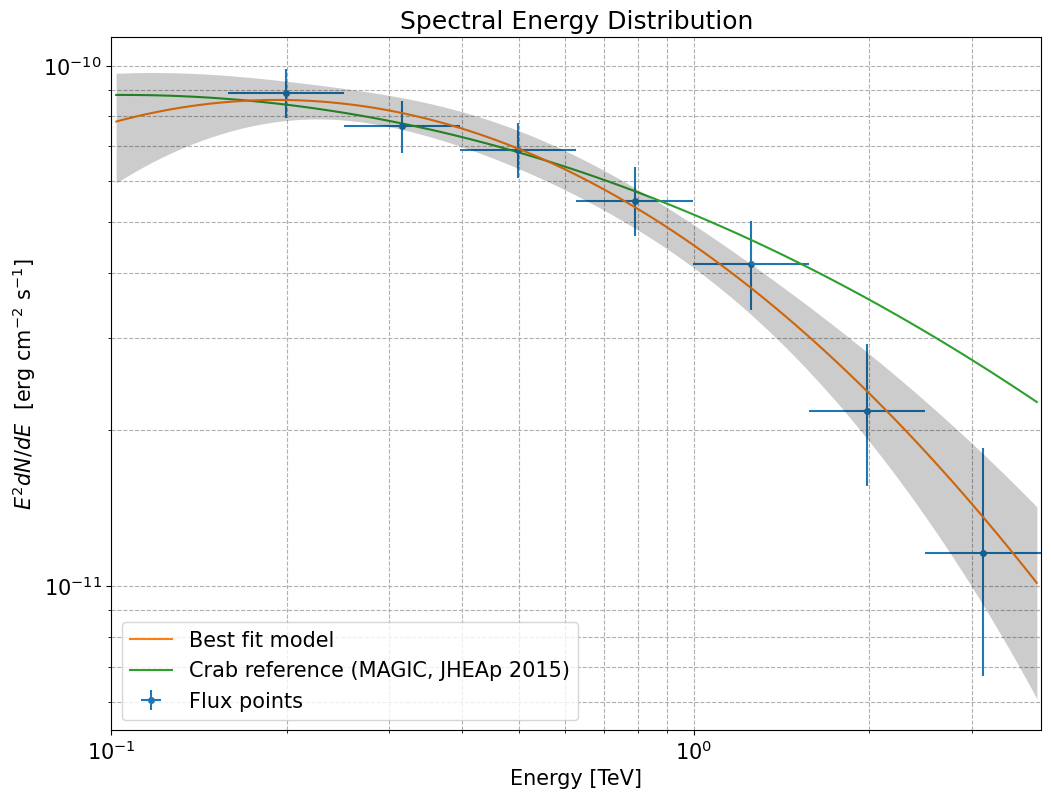

In [17]:
plt.figure()

plot_kwargs = {"sed_type": "e2dnde", "yunits": u.Unit("erg cm-2 s-1")}

# Plot the computed flux points:
ax = flux_points_dataset.plot_spectrum(kwargs_model=plot_kwargs)

# Draw the Crab reference spectrum:
create_crab_spectral_model("magic_lp").plot(
    ax=ax,
    energy_bounds=energy_axis.edges[[0, -1]],
    label="Crab reference (MAGIC, JHEAp 2015)",
    **plot_kwargs,
)

ax.set_title("Spectral Energy Distribution")
ax.set_ylabel("$E^2dN/dE$  [erg cm$^{-2}$ s$^{-1}$]")
ax.grid(which="both")
ax.legend(loc="lower left")